In [23]:
import pynapple as nap
from pathlib import Path

# TUMOR paths
# nwb_path = Path("/data_store2/neuropixels/nwb/NP128_B1.nwb") # has 0 and 1
# nwb_path = Path("/data_store2/neuropixels/nwb/NP150_B1.nwb") # has 0 and 1

# EPILEPSY paths
# nwb_path = Path("/data_store2/neuropixels/nwb/NP113_B1.nwb"), # has 0, 1, 2
# nwb_path = Path("/data_store2/neuropixels/nwb/NP134_B2.nwb") # has 0, 1, 2, 3
# nwb_path = Path("/data_store2/neuropixels/nwb/NP148_B2.nwb") # has 0 # CHECK THIS ONE, LOST IT
# nwb_path = Path("/data_store2/neuropixels/nwb/NP149_B1.nwb") # has 0

# make list of paths
nwb_paths = [
    Path("/data_store2/neuropixels/nwb/NP113_B1.nwb"),
    Path("/data_store2/neuropixels/nwb/NP128_B1.nwb"),
    Path("/data_store2/neuropixels/nwb/NP134_B2.nwb"), 
    Path("/data_store2/neuropixels/nwb/NP149_B1.nwb"),
    Path("/data_store2/neuropixels/nwb/NP150_B1.nwb"),
]

# make list of tumor ids and infiltrated ids
tumor_ids = [0, 1, 0, 0, 1]
infiltrated_ids = [0, 1, 0, 0, 0] # i.e. tumor, and not insular/opercular (will need to be confirmed)

In [42]:
import fnmatch
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from scipy.linalg import norm

# define variables to save out from loop
bin_counts_list = []
first_assembly_member_bin_counts_list = []
all_assembly_member_bin_counts_list = []
sparsity_list_list = []
bin_fx_list = []
cell_yield_list = []
assembly_yield_list = []
tumor_id_list = []
infiltrated_id_list = []
i_save = 0

# loop through all nwb files
for i in range(len(nwb_paths)):
    data = nap.load_file(nwb_paths[i])
    keys = data.keys()

    # find the spike TsGroup objects, number various based on recording apparatus
    template = "*imec*"
    keys = [key for key in keys if fnmatch.fnmatch(key, template)]
    template = "*Th=*" 
    keys = [key for key in keys if not fnmatch.fnmatch(key, template)]
    
    # loop through all individual probes
    for s in range(len(keys)):
        spike_times = data[keys[s]]
        # print(spike_times)
        
        # 1. filter to good neurons
        KSLabels = spike_times.metadata["KSLabel_repeat"]
        firingRates = spike_times.metadata["rate"]
        contamPct = spike_times.metadata["ContamPct"]

        mask1 = firingRates>0.5
        mask2 = contamPct<5
        mask3 = KSLabels=="good"
        combined_mask = mask1 & mask2 & mask3
        indices = firingRates[combined_mask].index

        # now apply ISI violation criteria to narrow down good neurons
        violationThreshold = 3/1000 #for 3 ms isi refractory period, lit standard
        violationPct = np.zeros(len(indices))
        ct = 0;
        for ii in indices:
            unit = spike_times[ii]
            unit = unit.as_series().index
            isi = unit.diff()[1:len(unit)]
            violations = np.where(isi<violationThreshold)
            violations = np.array(violations)
            violationPct[ct] = violations.size/len(isi)
            ct += 1
        # plt.hist(violationPct, bins = 20)
        mask = violationPct<5/100 # throwing out neurons with > 3% isi violations
        indicesFinal = indices[mask]
        print(keys[s])
        print(len(indicesFinal))



        # 2.  make spike rate matrix
        # now restrict spike times to the good neurons
        spike_times_good = spike_times[indicesFinal]
        # print(spike_times_good)

        # make spike count matrix
        timescale = 25/1000;
        spikeCountMatrix = spike_times_good.count(bin_size=timescale)
        spikeCountMatrix = spikeCountMatrix.values # matrix in spike counts
        firingRateMatrix = spikeCountMatrix/timescale # matrix in Hz
        firingRateMatrix = stats.zscore(firingRateMatrix, axis=0) # zscore across time (within neuron)



        # 3. run PCA to get first pass assembly patterns
        pca = PCA()

        # fit and transform data
        # note don't have to center bc each row is zscores so center of matrix is 0
        firingRateMatrix_pca = pca.fit_transform(firingRateMatrix)
        eigenvalues = pca.explained_variance_ 

        # calculate the upperbound of the Marchenko-Pastur law, eigenvalues above the 
        # upper bound are patterns that will be considered "assemblies"
        upperbound = (1+np.sqrt(firingRateMatrix.shape[1]/firingRateMatrix.shape[0]))**2

        # classic definition
        assemblyIndices = np.where(eigenvalues>upperbound)

        # more stringent definition
        # assemblyIndices = np.where((eigenvalues > upperbound) & (eigenvalues > np.mean(eigenvalues) + np.std(eigenvalues) * 2))

        # save assembly eigenvalues
        assemblyEigenvalues = eigenvalues[assemblyIndices]



        # 4. orthogonalize the assembly patterns with ICA
        # only get the assembly pca patterns
        n_pcs = len(assemblyEigenvalues) # only want the above threshold patterns
        pc_vectors = pca.components_[:n_pcs, :]

        # project the assembly pca patterns onto the firing rate matrix
        projections = firingRateMatrix @ pc_vectors.T

        # define and run the ICA
        fastica = FastICA(
            n_components=n_pcs,
            algorithm='parallel',
            whiten='unit-variance',
            max_iter=500,
            tol=1e-7,
            random_state=1
        )
        ica_components = fastica.fit_transform(projections)

        # get mixing and unmixing matrices
        mixing_matrix = fastica.mixing_
        unmixing_matrix = fastica.components_


        # 5. project the assembly patterns back to the original feature space (neurons)
        ica_assembly_patterns = unmixing_matrix @ pc_vectors  # Shape: (n_pcs, n_features)

        # define members, save out unit vectors and bool in matrices
        ap_norm_matrix = ica_assembly_patterns
        ap_norm_member = np.zeros(ica_assembly_patterns.shape)
        for ii in range(n_pcs):
            ap = ica_assembly_patterns[ii,:]
            ap_norm = ap/norm(ap)
            maxW = max(ap_norm);
            minW = min(ap_norm);
            if abs(minW) > maxW:
                ap_norm = ap_norm*-1
            ap_norm_matrix[ii,:] = ap_norm
            threshold = np.mean(ap_norm) + np.std(ap_norm) * 2
            for c in range(len(ap)):
                if ap_norm[c] > threshold:
                    ap_norm_member[ii,c] = 1


        # 6. split neurons into depth bins and visualize         
        probeDepth = 6000; # this is a dummy as actual value is not on the spreadsheet, this is about average

        str1 = keys[s]
        str2 = str1[0:11].replace("NP","catgt_NP")
        str3 = str1[0:8]

        positions = np.load(f'/data_store2/neuropixels/preproc/{str3}/kilosort/{str2}/{str1}/spike_positions.npy')
        clusters = np.load(f'/data_store2/neuropixels/preproc/{str3}/kilosort/{str2}/{str1}/spike_clusters.npy')

        # get the mean depth for each unit
        y_vals = np.zeros(len(indicesFinal));
        ct = 0;
        for ii in indicesFinal:
            y_vals[ct] = np.mean(positions[np.where(clusters==ii)], axis=0)[1]
            ct += 1

        depths = probeDepth - y_vals;
        depthBins = np.linspace(np.min(depths)-1,np.max(depths)+1,7) # just space it from min to max since don't know the insertion depth or cortical thickness

        # Assign each depth to a depth bin (0-based index)
        depth_bin_indices = np.digitize(depths, depthBins)

        # Visualize the ICA assembly patterns
        # Determine subplot grid: no more than 4 per row
        # n_cols = min(4, n_pcs)
        # n_rows = int(np.ceil(n_pcs / n_cols))
        # plt.figure(figsize=(5 * n_cols, 5 * n_rows))
        # plt.title(f"{keys[s]} (tumor_ind={tumor_ids[i]})")
        # for ii in range(n_pcs):
        #     row = ii // n_cols
        #     col = ii % n_cols
        #     plt.subplot(n_rows, n_cols, ii+1)
        #     # Sort neurons by depth and reorder the pattern matrix and membership accordingly
        #     sorted_indices = np.argsort(depths)
        #     sorted_depths = depths[sorted_indices]
        #     sorted_ap_norm_matrix = ap_norm_matrix[:, sorted_indices]
        #     sorted_ap_norm_member = ap_norm_member[:, sorted_indices]
        #     sorted_depth_bin_indices = depth_bin_indices[sorted_indices]

        #     plt.bar(range(sorted_ap_norm_matrix.shape[1]), sorted_ap_norm_matrix[ii, :])
        #     member_indices_sorted = np.where(sorted_ap_norm_member[ii, :] == 1)[0]
        #     plt.bar(member_indices_sorted, sorted_ap_norm_matrix[ii, member_indices_sorted], color='orange')
        #     plt.title(f'ICA Assembly Pattern {ii+1}')
        #     plt.xlabel('Neuron Index (sorted by depth)')
        #     plt.ylabel('Weight')

        #    # Draw vertical lines to delineate depth bins
        #     bin_transitions = np.where(np.diff(sorted_depth_bin_indices) != 0)[0]
        #     for bt in bin_transitions:
        #         plt.axvline(x=bt+0.5, color='red', linestyle='--', linewidth=1)

        # plt.grid(False)
        # plt.tight_layout()
        # plt.show()


        # # Plot histogram of all neuron depth bins
        #plt.figure(figsize=(3, 3))
        # n_bins = len(np.unique(depth_bin_indices))

        # Histogram for all neurons
        # plt.hist(depth_bin_indices, bins=np.arange(0.5, n_bins+1.5, 1), alpha=0.2, color='gray', label='All Neurons')

        # Histogram for member neurons (across all assemblies)
        # member_mask = np.any(ap_norm_member == 1, axis=0)  # shape: (n_neurons,)
        # member_depth_bins = depth_bin_indices[member_mask]
        # plt.hist(member_depth_bins, bins=np.arange(0.5, n_bins+1.5, 1), alpha=0.2, color='orange', label='Assembly Members')

        # plt.title(f"{keys[s]} (tumor_ind={tumor_ids[i]})")
        # plt.xlabel('Depth Bin')
        # plt.ylabel('Count')
        # plt.title(f"{keys[s]} (tumor_ind={tumor_ids[i]})")
        # plt.xticks(np.arange(1, n_bins+1), [f'Bin {ii}' for ii in range(1, n_bins+1)])
        # plt.legend()
        # plt.grid(axis='y')
        # plt.tight_layout()
        # plt.show()

        # Calculate the fraction of neurons in each depth bin
        n_bins = len(np.unique(depth_bin_indices))
        bin_counts = np.array([(depth_bin_indices == b).sum() for b in range(1, n_bins+1)])
        total_neurons = len(depth_bin_indices)
        fraction_per_bin = bin_counts / total_neurons
        # print("Fraction of neurons in each bin:", fraction_per_bin)

        # Calculate the percentage of total neurons that are member neurons to at least one assembly
        member_mask = np.any(ap_norm_member == 1, axis=0)
        n_member_neurons = np.sum(member_mask)
        percent_member_neurons = n_member_neurons / total_neurons
        # print(f"Percentage of neurons that are members of at least one assembly: {percent_member_neurons:.2f}%")

        # Get the indices of member neurons in the first assembly pattern (row 0)
        first_assembly_member_mask = ap_norm_member[0, :] == 1
        # Get the depth bins for these member neurons
        first_assembly_member_depth_bins = depth_bin_indices[first_assembly_member_mask]
        # Count the number of member neurons in each bin (bins are 1-indexed)
        first_assembly_member_bin_counts = np.array([(first_assembly_member_depth_bins == b).sum() for b in range(1, n_bins+1)])
        # print("Bin counts for members in the first assembly pattern:", first_assembly_member_bin_counts)

        # Get the depth bins for all assembly member neurons (across all assemblies)
        all_member_depth_bins = depth_bin_indices[member_mask]
        # Count the number of member neurons in each bin (bins are 1-indexed)
        all_member_bin_counts = np.array([(all_member_depth_bins == b).sum() for b in range(1, n_bins+1)])
        # print("Bin counts for all assembly members (across all assemblies):", all_member_bin_counts)

        # Calculate sparsity metric for each assembly
        sparsity_list = []
        sparsity_key = []
        for ap in range(len(ap_norm_matrix)):
            w = np.array(ap_norm_matrix[ap,:])
            n = w.size
            numerator = np.sqrt(n) - np.sum(np.abs(w))
            denominator = np.sqrt(n) - 1
            sparsity = 1 - numerator / denominator if denominator != 0 else np.nan
            sparsity_list.append(sparsity)
        # print("Sparsity metric for each assembly:", sparsity_list)

        # 7. save out variables
        bin_counts_list.append(bin_counts)
        first_assembly_member_bin_counts_list.append(first_assembly_member_bin_counts)
        all_assembly_member_bin_counts_list.append(all_member_bin_counts)
        sparsity_list_list.append(sparsity_list)
        bin_fx_list.append(fraction_per_bin)
        cell_yield_list.append(len(indicesFinal))
        assembly_yield_list.append(len(assemblyEigenvalues))
        tumor_id_list.append(tumor_ids[i])
        infiltrated_id_list.append(infiltrated_ids[i])
        i_save += 1


/userdata/ekato/miniforge3/envs/se2nwb/lib/python3.10/site-packages/pynapple/core/base_class.py:60: UserWarning: Some epochs have no duration
  self.time_support = IntervalSet(start=self.index[0], end=self.index[-1])
/userdata/ekato/miniforge3/envs/se2nwb/lib/python3.10/site-packages/pynapple/core/base_class.py:62: RuntimeWarning: divide by zero encountered in scalar divide
  self.rate = self.index.shape[0] / np.sum(


NP113_B1_g0_imec2_KS4
215


/userdata/ekato/miniforge3/envs/se2nwb/lib/python3.10/site-packages/pynapple/core/base_class.py:60: UserWarning: Some epochs have no duration
  self.time_support = IntervalSet(start=self.index[0], end=self.index[-1])
/userdata/ekato/miniforge3/envs/se2nwb/lib/python3.10/site-packages/pynapple/core/base_class.py:62: RuntimeWarning: divide by zero encountered in scalar divide
  self.rate = self.index.shape[0] / np.sum(


NP113_B1_g0_imec1_KS4
147


/userdata/ekato/miniforge3/envs/se2nwb/lib/python3.10/site-packages/pynapple/core/base_class.py:60: UserWarning: Some epochs have no duration
  self.time_support = IntervalSet(start=self.index[0], end=self.index[-1])
/userdata/ekato/miniforge3/envs/se2nwb/lib/python3.10/site-packages/pynapple/core/base_class.py:62: RuntimeWarning: divide by zero encountered in scalar divide
  self.rate = self.index.shape[0] / np.sum(


NP113_B1_g0_imec0_KS4
103


/userdata/ekato/miniforge3/envs/se2nwb/lib/python3.10/site-packages/pynapple/core/base_class.py:60: UserWarning: Some epochs have no duration
  self.time_support = IntervalSet(start=self.index[0], end=self.index[-1])
/userdata/ekato/miniforge3/envs/se2nwb/lib/python3.10/site-packages/pynapple/core/base_class.py:62: RuntimeWarning: divide by zero encountered in scalar divide
  self.rate = self.index.shape[0] / np.sum(


NP128_B1_g0_imec1_KS4
83


/userdata/ekato/miniforge3/envs/se2nwb/lib/python3.10/site-packages/pynapple/core/base_class.py:60: UserWarning: Some epochs have no duration
  self.time_support = IntervalSet(start=self.index[0], end=self.index[-1])
/userdata/ekato/miniforge3/envs/se2nwb/lib/python3.10/site-packages/pynapple/core/base_class.py:62: RuntimeWarning: divide by zero encountered in scalar divide
  self.rate = self.index.shape[0] / np.sum(


NP128_B1_g0_imec0_KS4
15
NP134_B2_g0_imec3_KS4
162


/userdata/ekato/miniforge3/envs/se2nwb/lib/python3.10/site-packages/pynapple/core/base_class.py:60: UserWarning: Some epochs have no duration
  self.time_support = IntervalSet(start=self.index[0], end=self.index[-1])
/userdata/ekato/miniforge3/envs/se2nwb/lib/python3.10/site-packages/pynapple/core/base_class.py:62: RuntimeWarning: divide by zero encountered in scalar divide
  self.rate = self.index.shape[0] / np.sum(


NP134_B2_g0_imec2_KS4
203


/userdata/ekato/miniforge3/envs/se2nwb/lib/python3.10/site-packages/pynapple/core/base_class.py:60: UserWarning: Some epochs have no duration
  self.time_support = IntervalSet(start=self.index[0], end=self.index[-1])
/userdata/ekato/miniforge3/envs/se2nwb/lib/python3.10/site-packages/pynapple/core/base_class.py:62: RuntimeWarning: divide by zero encountered in scalar divide
  self.rate = self.index.shape[0] / np.sum(


NP134_B2_g0_imec1_KS4
143
NP134_B2_g0_imec0_KS4
110


/userdata/ekato/miniforge3/envs/se2nwb/lib/python3.10/site-packages/pynapple/core/base_class.py:60: UserWarning: Some epochs have no duration
  self.time_support = IntervalSet(start=self.index[0], end=self.index[-1])
/userdata/ekato/miniforge3/envs/se2nwb/lib/python3.10/site-packages/pynapple/core/base_class.py:62: RuntimeWarning: divide by zero encountered in scalar divide
  self.rate = self.index.shape[0] / np.sum(


NP149_B1_g0_imec0_KS4
67


/userdata/ekato/miniforge3/envs/se2nwb/lib/python3.10/site-packages/pynapple/core/base_class.py:60: UserWarning: Some epochs have no duration
  self.time_support = IntervalSet(start=self.index[0], end=self.index[-1])
/userdata/ekato/miniforge3/envs/se2nwb/lib/python3.10/site-packages/pynapple/core/base_class.py:62: RuntimeWarning: divide by zero encountered in scalar divide
  self.rate = self.index.shape[0] / np.sum(


NP150_B1_g0_imec1_KS4
36


/userdata/ekato/miniforge3/envs/se2nwb/lib/python3.10/site-packages/pynapple/core/base_class.py:60: UserWarning: Some epochs have no duration
  self.time_support = IntervalSet(start=self.index[0], end=self.index[-1])
/userdata/ekato/miniforge3/envs/se2nwb/lib/python3.10/site-packages/pynapple/core/base_class.py:62: RuntimeWarning: divide by zero encountered in scalar divide
  self.rate = self.index.shape[0] / np.sum(


NP150_B1_g0_imec0_KS4
37


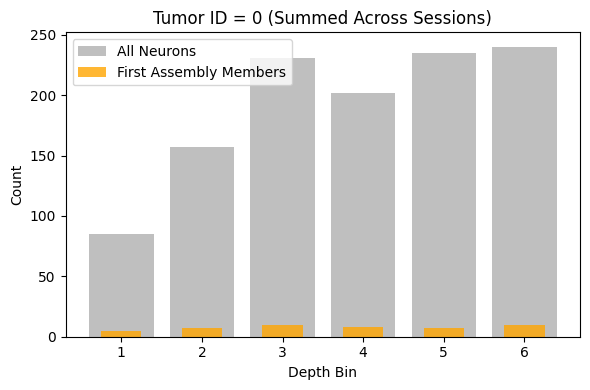

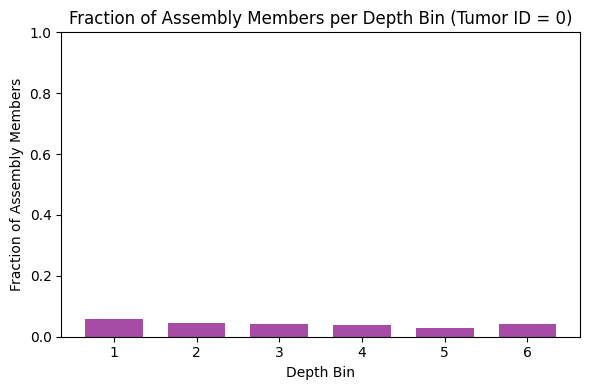

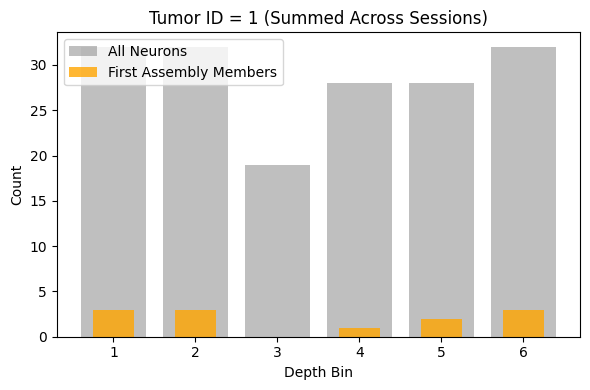

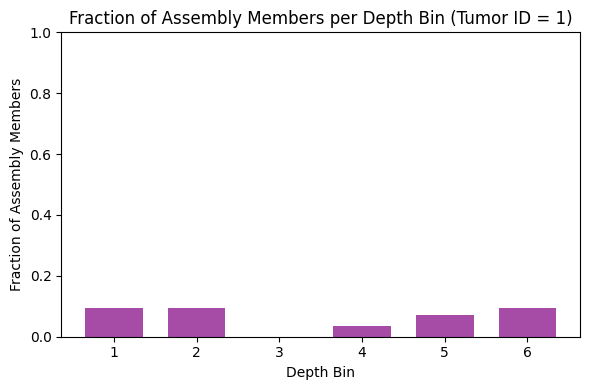

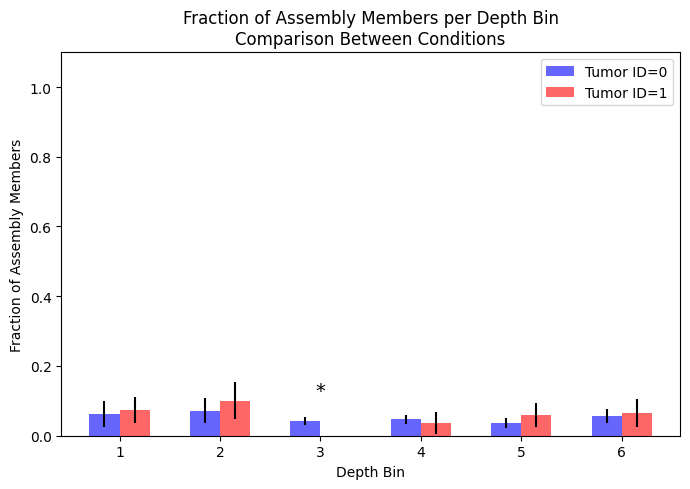

Depth Bin 1: t=-0.19, p=0.8569
Depth Bin 2: t=-0.39, p=0.7081
Depth Bin 3: t=3.38, p=0.0118
Depth Bin 4: t=0.30, p=0.7790
Depth Bin 5: t=-0.54, p=0.6153
Depth Bin 6: t=-0.18, p=0.8645


In [43]:
# now do some analysis on the saved out variables
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind

# Convert lists to numpy arrays for easier indexing
bin_counts_arr = np.array(bin_counts_list)  # shape: (n_sessions, n_bins)

# note: can change this from first_ to all_ to compare just first or all so that don't have to duplicate code
first_assembly_member_bin_counts_arr = np.array(first_assembly_member_bin_counts_list)  # shape: (n_sessions, n_bins)

# note: can change this from tumor_ to infiltrated_ to compare just tumor or infiltrated so that don't have to duplicate code
tumor_id_arr = np.array(tumor_id_list)

# Get unique tumor_id conditions (should be 0 and 1)
unique_tumor_ids = np.unique(tumor_id_arr)

# Store per-session fractions for stats
fraction_per_session = {}

for tid in unique_tumor_ids:
    # Find indices for this tumor_id
    idxs = np.where(tumor_id_arr == tid)[0]
    if len(idxs) == 0:
        continue

    # Sum across all sessions for this tumor_id
    summed_bin_counts = np.sum(bin_counts_arr[idxs], axis=0)
    summed_first_assembly_member_bin_counts = np.sum(first_assembly_member_bin_counts_arr[idxs], axis=0)

    plt.figure(figsize=(6,4))
    bins = np.arange(1, len(summed_bin_counts)+2) - 0.5  # bin edges for bar plots

    # Plot all neuron bin counts (background)
    plt.bar(np.arange(1, len(summed_bin_counts)+1), summed_bin_counts, 
            width=0.8, color='gray', alpha=0.5, label='All Neurons')

    # Overlay first assembly member bin counts
    plt.bar(np.arange(1, len(summed_first_assembly_member_bin_counts)+1), 
            summed_first_assembly_member_bin_counts, 
            width=0.5, color='orange', alpha=0.8, label='First Assembly Members')

    plt.xlabel('Depth Bin')
    plt.ylabel('Count')
    plt.title(f'Tumor ID = {tid} (Summed Across Sessions)')
    plt.xticks(np.arange(1, len(summed_bin_counts)+1))
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- Fraction plot ---
    # To avoid division by zero, mask bins with zero total neurons
    with np.errstate(divide='ignore', invalid='ignore'):
        fraction = np.zeros_like(summed_first_assembly_member_bin_counts, dtype=float)
        mask = summed_bin_counts > 0
        fraction[mask] = summed_first_assembly_member_bin_counts[mask] / summed_bin_counts[mask]
        fraction[~mask] = np.nan  # or 0, but nan is more explicit

    plt.figure(figsize=(6,4))
    plt.bar(np.arange(1, len(fraction)+1), fraction, width=0.7, color='purple', alpha=0.7)
    plt.xlabel('Depth Bin')
    plt.ylabel('Fraction of Assembly Members')
    plt.title(f'Fraction of Assembly Members per Depth Bin (Tumor ID = {tid})')
    plt.ylim(0, 1)
    plt.xticks(np.arange(1, len(fraction)+1))
    plt.tight_layout()
    plt.show()

    # Store per-session fractions for stats
    # shape: (n_sessions_in_group, n_bins)
    with np.errstate(divide='ignore', invalid='ignore'):
        per_session_fraction = np.zeros_like(first_assembly_member_bin_counts_arr[idxs], dtype=float)
        mask = bin_counts_arr[idxs] > 0
        per_session_fraction[mask] = first_assembly_member_bin_counts_arr[idxs][mask] / bin_counts_arr[idxs][mask]
        per_session_fraction[~mask] = np.nan
    fraction_per_session[tid] = per_session_fraction

# --- Statistical comparison between conditions for each depth bin ---
# Only proceed if both conditions are present
if len(unique_tumor_ids) == 2:
    tid0, tid1 = unique_tumor_ids
    frac0 = fraction_per_session[tid0]  # shape: (n_sessions0, n_bins)
    frac1 = fraction_per_session[tid1]  # shape: (n_sessions1, n_bins)
    n_bins = frac0.shape[1]

    pvals = []
    tvals = []
    for b in range(n_bins):
        # Remove nan values for t-test
        x0 = frac0[:, b]
        x1 = frac1[:, b]
        x0 = x0[~np.isnan(x0)]
        x1 = x1[~np.isnan(x1)]
        if len(x0) > 1 and len(x1) > 1:
            tval, pval = ttest_ind(x0, x1, equal_var=False, nan_policy='omit')
        else:
            tval, pval = np.nan, np.nan
        tvals.append(tval)
        pvals.append(pval)

    # Plot the mean and SEM for each group, with significance stars
    def sem(x):
        return np.nanstd(x, axis=0) / np.sqrt(np.sum(~np.isnan(x), axis=0))

    means0 = np.nanmean(frac0, axis=0)
    sems0 = sem(frac0)
    means1 = np.nanmean(frac1, axis=0)
    sems1 = sem(frac1)

    plt.figure(figsize=(7,5))
    x = np.arange(1, n_bins+1)
    plt.bar(x-0.15, means0, width=0.3, yerr=sems0, color='blue', alpha=0.6, label=f'Tumor ID={tid0}')
    plt.bar(x+0.15, means1, width=0.3, yerr=sems1, color='red', alpha=0.6, label=f'Tumor ID={tid1}')

    # Add significance stars
    for b in range(n_bins):
        if np.isnan(pvals[b]):
            continue
        if pvals[b] < 0.001:
            star = '***'
        elif pvals[b] < 0.01:
            star = '**'
        elif pvals[b] < 0.05:
            star = '*'
        else:
            star = ''
        if star:
            y_max = max(means0[b]+sems0[b], means1[b]+sems1[b])
            plt.text(x[b], y_max + 0.05, star, ha='center', va='bottom', color='k', fontsize=14)

    plt.xlabel('Depth Bin')
    plt.ylabel('Fraction of Assembly Members')
    plt.title('Fraction of Assembly Members per Depth Bin\nComparison Between Conditions')
    plt.ylim(0, 1.1)
    plt.xticks(x)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Print p-values for each bin
    for b in range(n_bins):
        print(f"Depth Bin {b+1}: t={tvals[b]:.2f}, p={pvals[b]:.4f}")





n0=8, mean0=0.531 ± 0.090
n1=4, mean1=0.604 ± 0.098
t=-1.17, p=0.2680


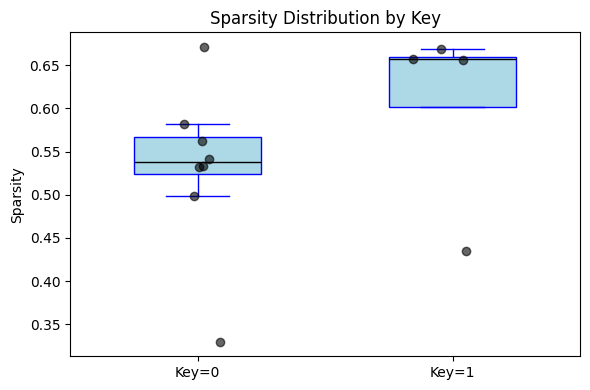

In [68]:
# Sparsity analysis using all values in sparsity_list_list

# Flatten all sparsity values and corresponding keys
all_sparsity = []
all_keys = []

# for sparsity_vals, key in zip(sparsity_list_list, tumor_ids):
#     all_sparsity.extend(sparsity_vals)
#     all_keys.extend([key] * len(sparsity_vals))

# do this for only first assembly
for ii in range(len(sparsity_list_list)):
    all_sparsity.append(sparsity_list_list[ii][0])
    all_keys.append(tumor_id_list[ii])

all_sparsity = np.array(all_sparsity)
all_keys = np.array(all_keys)

# Split by key
sparsity_0 = all_sparsity[all_keys == 0]
sparsity_1 = all_sparsity[all_keys == 1]

# Print summary statistics
print(f"n0={len(sparsity_0)}, mean0={np.mean(sparsity_0):.3f} ± {np.std(sparsity_0):.3f}")
print(f"n1={len(sparsity_1)}, mean1={np.mean(sparsity_1):.3f} ± {np.std(sparsity_1):.3f}")

# Run statistical test (two-sample t-test)
from scipy.stats import ttest_ind
tval, pval = ttest_ind(sparsity_0, sparsity_1, nan_policy='omit')
print(f"t={tval:.2f}, p={pval:.4f}")

# Box and whisker plot with all individual data points overlaid
plt.figure(figsize=(6,4))
data = [sparsity_0, sparsity_1]
positions = [1, 2]
plt.boxplot(
    data,
    positions=positions,
    patch_artist=True,
    boxprops=dict(facecolor='lightblue', color='blue'),
    medianprops=dict(color='black'),
    whiskerprops=dict(color='blue'),
    capprops=dict(color='blue'),
    flierprops=dict(markerfacecolor='blue', marker='', markersize=5, alpha=0.5),
    widths=0.5
)

# Overlay all individual data points (jittered)
for i, y in enumerate(data):
    x = np.random.normal(positions[i], 0.06, size=len(y))  # jitter
    plt.plot(x, y, 'o', color='k', alpha=0.6, markersize=6)

plt.ylabel('Sparsity')
plt.title('Sparsity Distribution by Key')
plt.xticks(positions, ['Key=0', 'Key=1'])
plt.tight_layout()
plt.show()
